In [1]:
import cv2
import numpy as np
import pywt
from matplotlib import pyplot as plt

def display_images(images, titles):
    num_images = len(images)
    cols = 3
    rows = (num_images + cols - 1) // cols

    plt.figure(figsize=(15, 10))

    for i in range(num_images):
        plt.subplot(rows, cols, i + 1)
        if len(images[i].shape) == 2:
            plt.imshow(images[i], cmap='gray')
        else:
            plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        plt.title(titles[i])
        plt.axis('off')

    plt.show()

def compress_jpeg(image, quality):
    encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), quality]
    _, compressed_image = cv2.imencode('.jpg', image, encode_param)
    decompressed_image = cv2.imdecode(compressed_image, cv2.IMREAD_COLOR)
    return decompressed_image

def compress_fourier(image, keep_fraction=0.1):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    f = np.fft.fft2(gray_image)
    fshift = np.fft.fftshift(f)
    
    rows, cols = gray_image.shape
    crow, ccol = rows // 2, cols // 2
    fshift[crow-int(crow*keep_fraction):crow+int(crow*keep_fraction), 
           ccol-int(ccol*keep_fraction):ccol+int(ccol*keep_fraction)] = 0
    
    f_ishift = np.fft.ifftshift(fshift)
    img_back = np.fft.ifft2(f_ishift)
    img_back = np.abs(img_back)
    img_back = np.uint8(255 * img_back / np.max(img_back))
    return img_back

def reduce_resolution(image, scale_percent):
    width = int(image.shape[1] * scale_percent)
    height = int(image.shape[0] * scale_percent)
    dim = (width, height)
    resized_image = cv2.resize(image, dim, interpolation=cv2.INTER_AREA)
    return resized_image

def compress_dct(image, keep_fraction=0.1):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    dct = cv2.dct(np.float32(gray_image))

    rows, cols = dct.shape
    crow, ccol = int(rows * keep_fraction), int(cols * keep_fraction)
    dct[crow:, ccol:] = 0
    
    img_back = cv2.idct(dct)
    img_back = np.clip(img_back, 0, 255)
    img_back = np.uint8(255 * img_back / np.max(img_back))
    return img_back

def compress_wavelet(image, wavelet='haar', level=1):
    # Converter para escala de cinza
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Aplicar a Transformada Wavelet
    coeffs = pywt.wavedec2(gray_image, wavelet, level=level)

    # Reduzir a magnitude dos coeficientes de detalhe
    coeffs_H = [coeffs[0]]  # Manter os coeficientes de aproximação
    for i in range(1, len(coeffs)):
        cH, cV, cD = coeffs[i]
        cH = np.multiply(cH, 0.1)  # Reduzir a magnitude dos detalhes horizontais
        cV = np.multiply(cV, 0.1)  # Reduzir a magnitude dos detalhes verticais
        cD = np.multiply(cD, 0.1)  # Reduzir a magnitude dos detalhes diagonais
        coeffs_H.append((cH, cV, cD))

    # Reconstruir a imagem comprimida
    compressed_image = pywt.waverec2(coeffs_H, wavelet)
    compressed_image = np.clip(compressed_image, 0, 255)
    return np.uint8(compressed_image)


In [2]:
def apply_median_filter(image, kernel_size=3):
    return cv2.medianBlur(image, kernel_size)

def apply_unsharp_mask(image, kernel_size=5, alpha=1.5):
    blurred = cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)
    return cv2.addWeighted(image, 1 + alpha, blurred, -alpha, 0)

def add_noise(image, noise_type="gaussian", mean=0, var=0.01, amount=0.05):
    if noise_type == "gaussian":
        row, col, ch = image.shape
        sigma = var ** 0.5
        gauss = np.random.normal(mean, sigma, (row, col, ch))
        noisy_image = image + gauss.reshape(row, col, ch)
        noisy_image = np.clip(noisy_image, 0, 255)
        return np.uint8(noisy_image)
    
    elif noise_type == "salt_n_pepper":
        row, col, ch = image.shape
        s_vs_p = 0.5
        noisy_image = np.copy(image)
        
        # Salt
        num_salt = np.ceil(amount * image.size * s_vs_p)
        coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image.shape]
        noisy_image[coords[0], coords[1], :] = 255
        
        # Pepper
        num_pepper = np.ceil(amount * image.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape]
        noisy_image[coords[0], coords[1], :] = 0
        
        return noisy_image

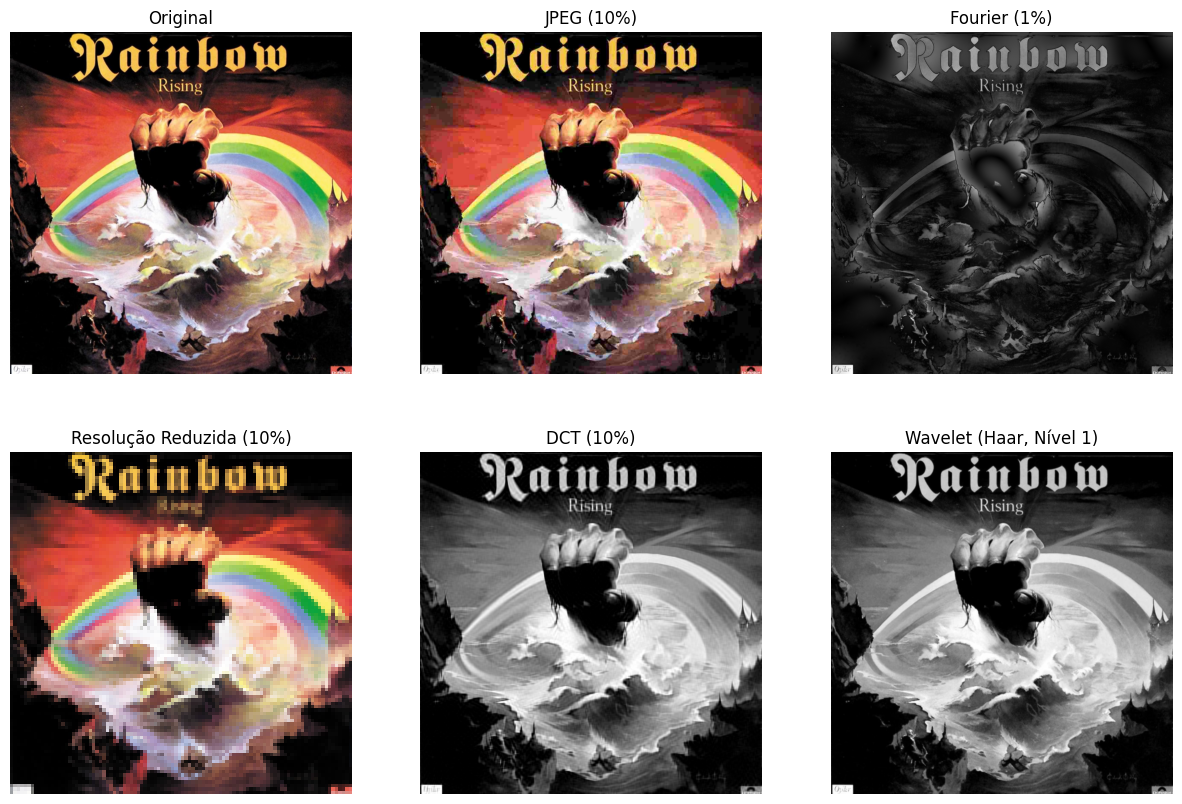

In [3]:
image_path = 'rising.jpg'
image = cv2.imread(image_path)

#image = add_noise(image, noise_type="gaussian", mean=0.5, var=0.1)
#image = add_noise(image, noise_type="salt_n_pepper", amount=0.01)

jpeg = compress_jpeg(image, quality = 10)  # Qualidade 10%
fourier = compress_fourier(image, keep_fraction = 0.01)  # Mantém 1% dos coeficientes
low_res = reduce_resolution(image, scale_percent = 0.1)  # Reduz para 10% da resolução original
dct = compress_dct(image, keep_fraction = 0.1)  # Mantém 10% dos coeficientes da DCT
wavelet = compress_wavelet(image, wavelet = 'haar', level = 1)  # Nível 1 da Wavelet 'haar'

images = [image, jpeg, fourier, low_res, dct, wavelet]

titles = [
    'Original', 
    'JPEG (10%)', 
    'Fourier (1%)', 
    'Resolução Reduzida (10%)', 
    'DCT (10%)', 
    'Wavelet (Haar, Nível 1)'
]

display_images(images, titles)

#images = [apply_unsharp_mask(apply_median_filter(img)) for img in images]
#display_images(images, titles)

In [4]:
import os
from skimage.measure import shannon_entropy

# Função para calcular a entropia
def calculate_entropy(image):
    if len(image.shape) == 3:
       image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return shannon_entropy(image)

# Função para calcular a razão de compressão
def calculate_compression_ratio(original, compressed):
    return original / compressed

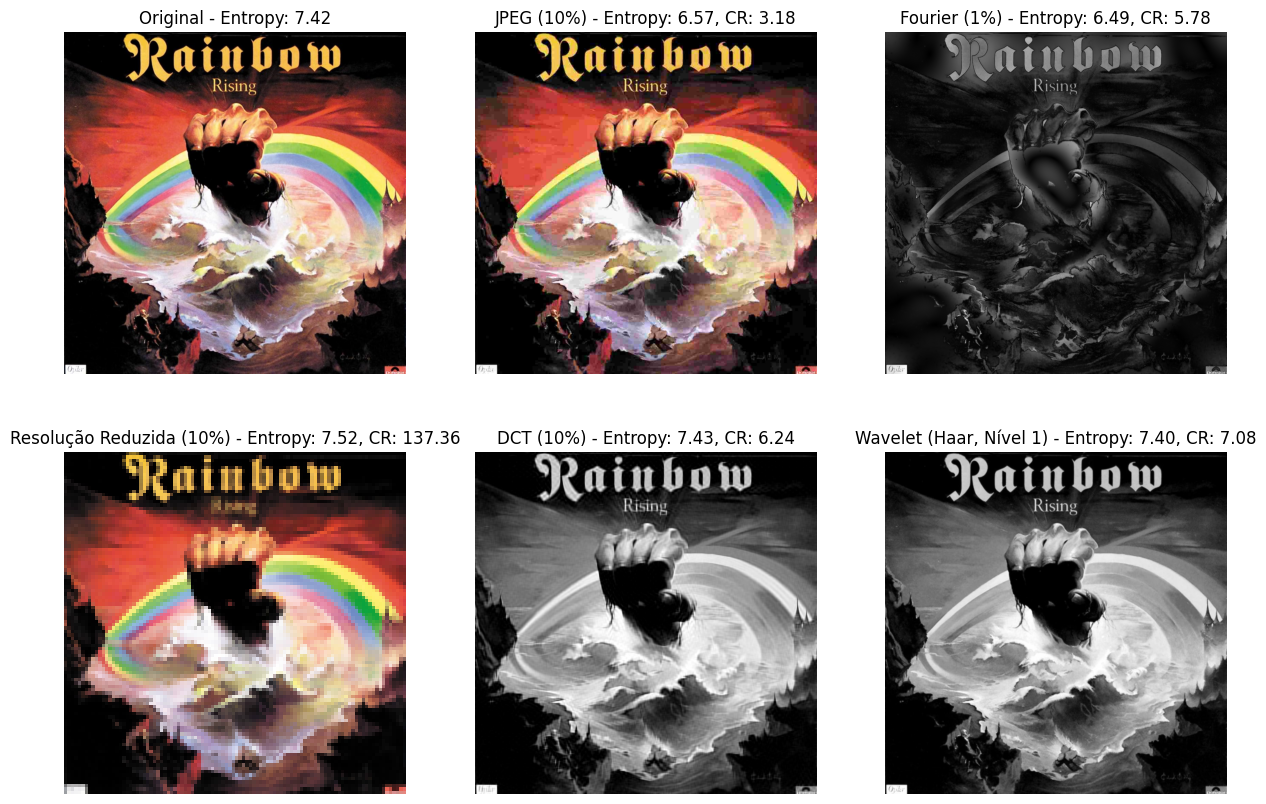

In [5]:
entropy_values = [calculate_entropy(img) for img in images]

cv2.imwrite('compressed_j_image.png', jpeg)
jpegC = os.path.getsize('compressed_j_image.png')


cv2.imwrite('compressed_f_image.png', fourier)
fourierC = os.path.getsize('compressed_f_image.png')


cv2.imwrite('compressed_l_image.png', low_res)
lowC = os.path.getsize('compressed_l_image.png')


cv2.imwrite('compressed_d_image.png', dct)
dctC = os.path.getsize('compressed_d_image.png')


cv2.imwrite('compressed_w_image.png', wavelet)
waveletC = os.path.getsize('compressed_w_image.png')

sizes = [jpegC, fourierC, lowC, dctC, waveletC]

compression_ratios = [calculate_compression_ratio(image.nbytes, size) for size in sizes]

titles = [
    f'Original - Entropy: {entropy_values[0]:.2f}', 
    f'JPEG (10%) - Entropy: {entropy_values[1]:.2f}, CR: {compression_ratios[0]:.2f}', 
    f'Fourier (1%) - Entropy: {entropy_values[2]:.2f}, CR: {compression_ratios[1]:.2f}', 
    f'Resolução Reduzida (10%) - Entropy: {entropy_values[3]:.2f}, CR: {compression_ratios[2]:.2f}', 
    f'DCT (10%) - Entropy: {entropy_values[4]:.2f}, CR: {compression_ratios[3]:.2f}', 
    f'Wavelet (Haar, Nível 1) - Entropy: {entropy_values[5]:.2f}, CR: {compression_ratios[4]:.2f}'
]

display_images(images,titles)

In [6]:
from skimage import img_as_float
from skimage.restoration import estimate_sigma
from skimage.feature import graycomatrix, graycoprops
from skimage.util import img_as_ubyte
from scipy.stats import kurtosis, skew

def calculate_brisque(image):
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Converter a imagem para float para evitar problemas na normalização
    image = img_as_float(image)

    # Calcular propriedades estatísticas locais
    sigma = estimate_sigma(image, average_sigmas=True)
    g_matrix = graycomatrix(img_as_ubyte(image), distances=[1], angles=[0], symmetric=True, normed=True)
    contrast = graycoprops(g_matrix, 'contrast')[0, 0]
    energy = graycoprops(g_matrix, 'energy')[0, 0]
    homogeneity = graycoprops(g_matrix, 'homogeneity')[0, 0]
    correlation = graycoprops(g_matrix, 'correlation')[0, 0]
    
    # Calcular a kurtose e a assimetria (skewness) da imagem
    img_kurtosis = kurtosis(image.ravel())
    img_skewness = skew(image.ravel())

    # Combinar as propriedades para formar um score (exemplo simplificado)
    brisque_score = sigma + contrast + energy + homogeneity + correlation + abs(img_kurtosis) + abs(img_skewness)
    
    return brisque_score

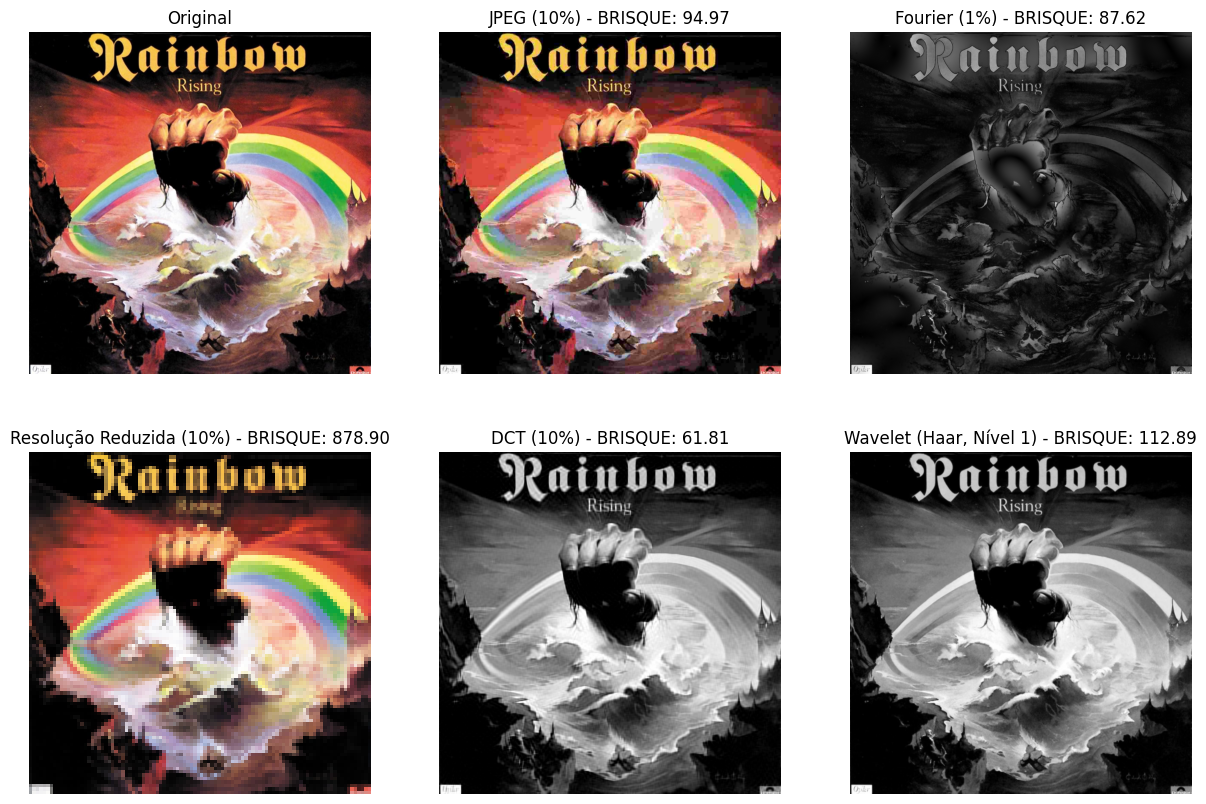

In [7]:
# Calcular o BRISQUE para cada método
brisque_values = [calculate_brisque(img) for img in images]

titles = [
    f'Original', 
    f'JPEG (10%) - BRISQUE: {brisque_values[1]:.2f}', 
    f'Fourier (1%) - BRISQUE: {brisque_values[2]:.2f}', 
    f'Resolução Reduzida (10%) - BRISQUE: {brisque_values[3]:.2f}', 
    f'DCT (10%) - BRISQUE: {brisque_values[4]:.2f}', 
    f'Wavelet (Haar, Nível 1) - BRISQUE: {brisque_values[5]:.2f}'
]

display_images(images, titles)

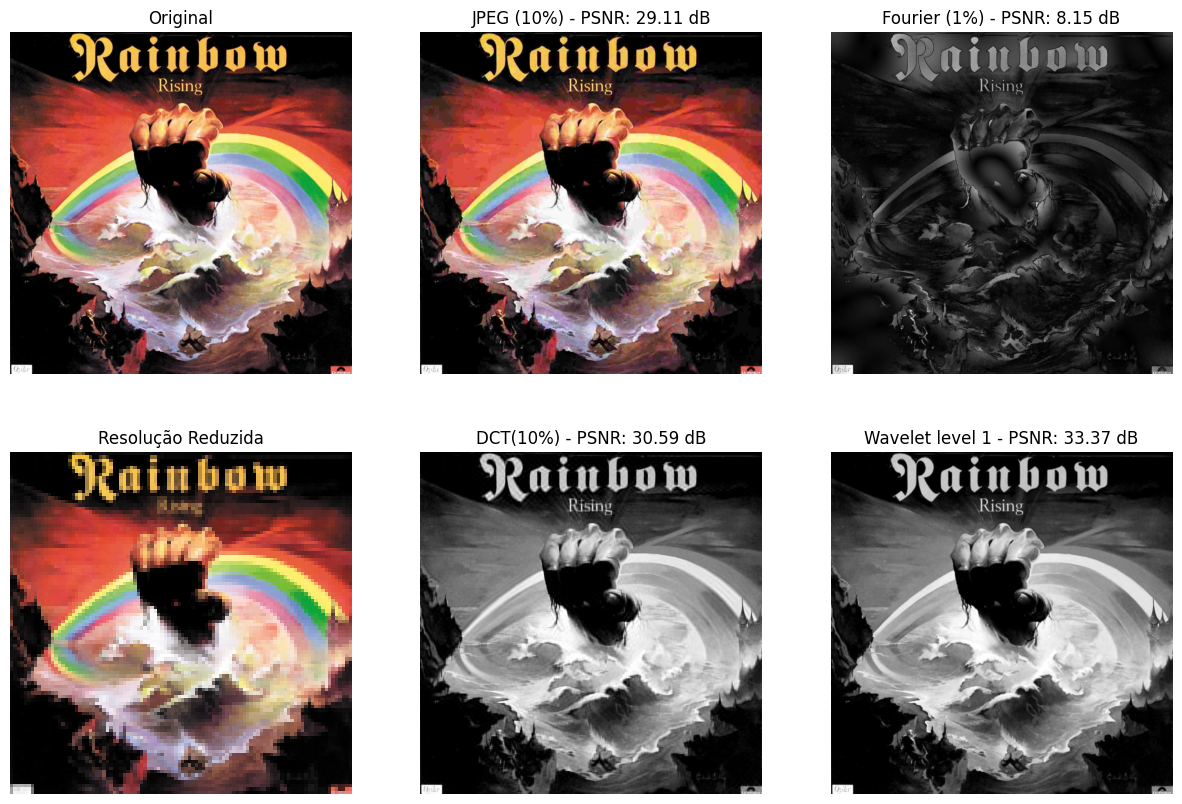

In [8]:
from skimage.metrics import peak_signal_noise_ratio

def calculate_psnr(original, compressed):
    if len(original.shape) == 3 and len(compressed.shape) == 2:
        original = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
    elif len(original.shape) == 2 and len(compressed.shape) == 3:
        compressed = cv2.cvtColor(compressed, cv2.COLOR_BGR2GRAY)

    psnr_value = peak_signal_noise_ratio(original, compressed, data_range=255)
    return psnr_value


psnr_values1 = [calculate_psnr(image, img) for img in images[1:3]]
psnr_values2 = [calculate_psnr(image, img) for img in images[4:]]

titles = [
    f'Original', 
    f'JPEG (10%) - PSNR: {psnr_values1[0]:.2f} dB',
    f'Fourier (1%) - PSNR: {psnr_values1[1]:.2f} dB',
    f'Resolução Reduzida', 
    f'DCT(10%) - PSNR: {psnr_values2[0]:.2f} dB',
    f'Wavelet level 1 - PSNR: {psnr_values2[1]:.2f} dB',
]

display_images(images,titles)

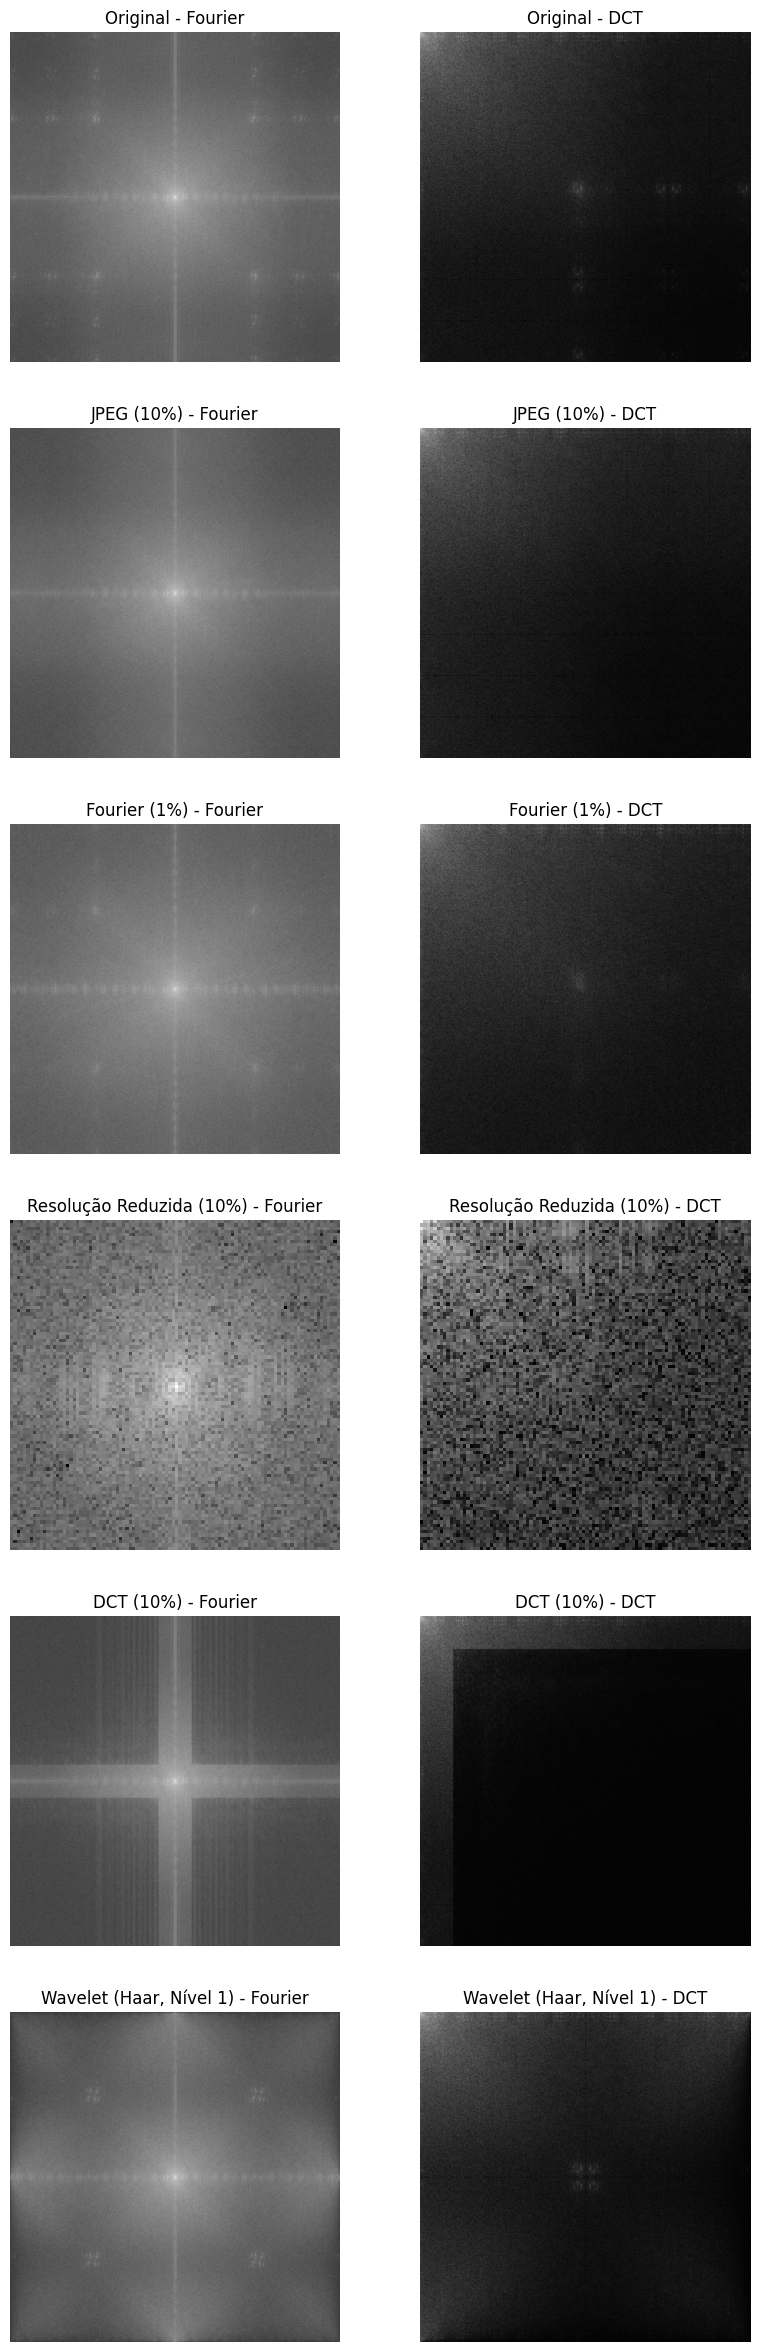

In [9]:
# Função para análise de Fourier
def analyze_fourier(image):
    if len(image.shape) == 2:  # Já é uma imagem em escala de cinza
        gray_image = image
    elif len(image.shape) == 3 and image.shape[2] == 3:  # Imagem colorida
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    f = np.fft.fft2(gray_image)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = 20 * np.log(np.abs(fshift) + 1)
    return magnitude_spectrum

# Função para análise de DCT
def analyze_dct(image):
    if len(image.shape) == 2:  # Já é uma imagem em escala de cinza
        gray_image = image
    elif len(image.shape) == 3 and image.shape[2] == 3:  # Imagem colorida
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    dct = cv2.dct(np.float32(gray_image))
    magnitude_spectrum = np.log(np.abs(dct) + 1)
    return magnitude_spectrum

# Função para exibir as análises de frequência das imagens
def display_frequency_analysis(images, titles):
    num_images = len(images)
    cols = 3  # Definindo número de colunas para Fourier, DCT e Wavelet
    rows = num_images  # Cada imagem terá uma linha

    plt.figure(figsize=(15, rows * 5))

    for i in range(num_images):
        # Analisar Fourier
        plt.subplot(rows, cols, i * cols + 1)
        fourier_spectrum = analyze_fourier(images[i])
        plt.imshow(fourier_spectrum, cmap='gray')
        plt.title(f'{titles[i]} - Fourier')
        plt.axis('off')

        # Analisar DCT
        plt.subplot(rows, cols, i * cols + 2)
        dct_spectrum = analyze_dct(images[i])
        plt.imshow(dct_spectrum, cmap='gray')
        plt.title(f'{titles[i]} - DCT')
        plt.axis('off')

    plt.show()

images = [image, jpeg, fourier, low_res, dct, wavelet]

titles = [
    'Original', 
    'JPEG (10%)', 
    'Fourier (1%)', 
    'Resolução Reduzida (10%)', 
    'DCT (10%)', 
    'Wavelet (Haar, Nível 1)'
]

display_frequency_analysis(images,titles)

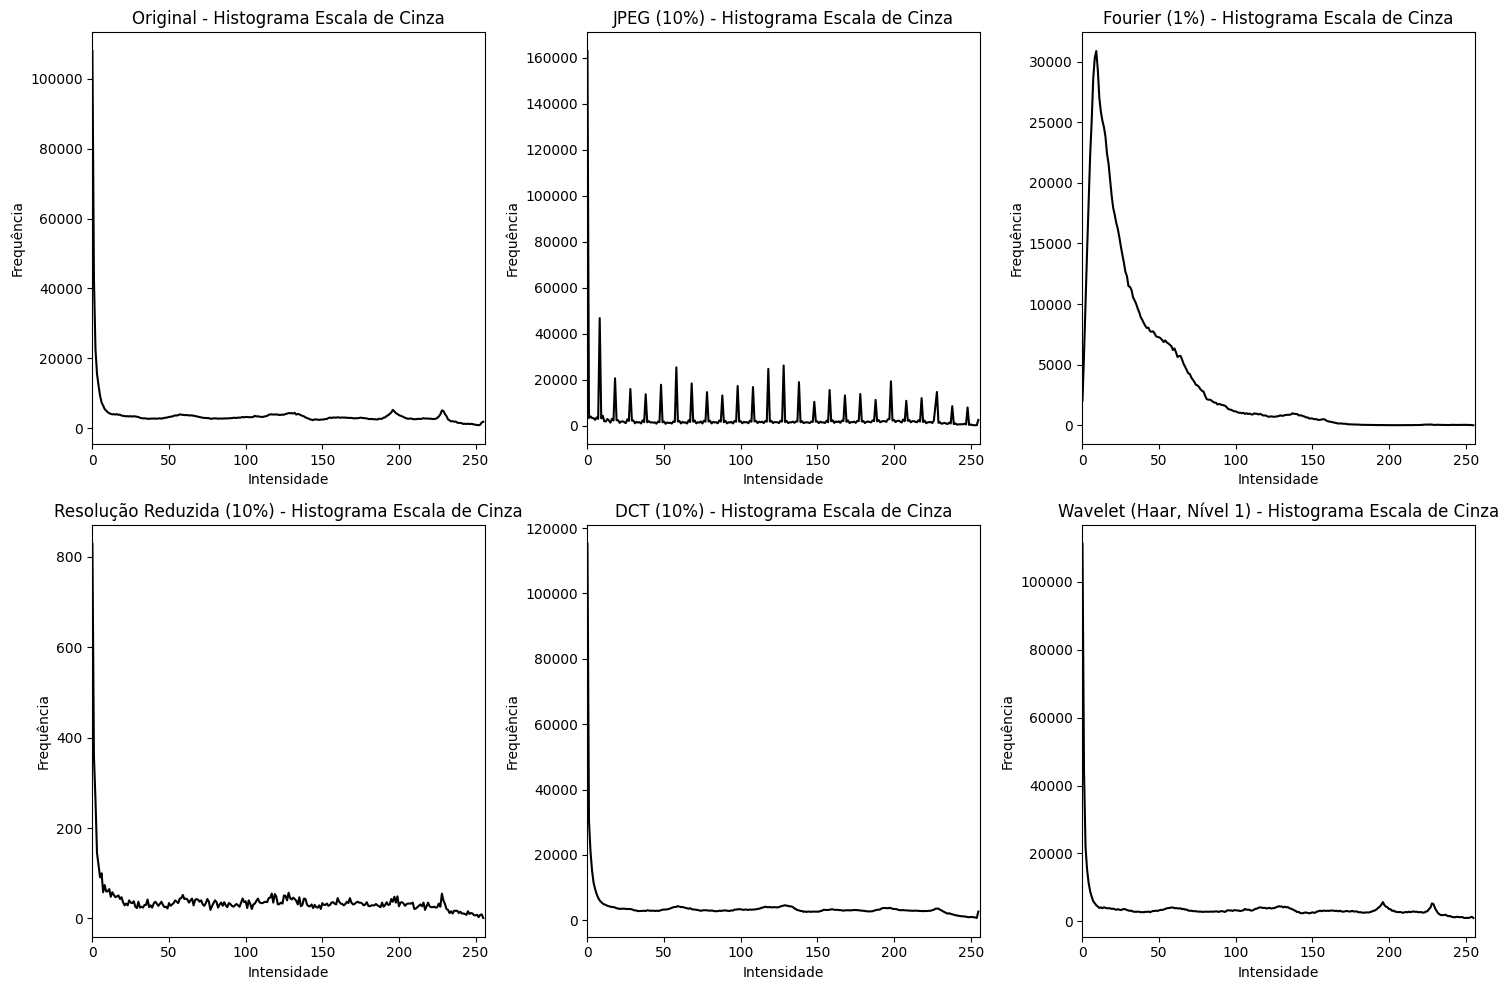

In [10]:
def calculate_gray_histogram(image):
    """Calcula o histograma para uma imagem em escala de cinza."""
    if len(image.shape) == 3:  # Imagem colorida
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray_image = image  # Já é em escala de cinza
    histogram = cv2.calcHist([gray_image], [0], None, [256], [0, 256])
    return histogram

def display_gray_histogram_comparison(images, titles):
    """Exibe os histogramas em escala de cinza para uma lista de imagens."""
    num_images = len(images)
    cols = 3  # Número de colunas para o layout
    rows = (num_images + cols - 1) // cols  # Número de linhas, ajustado para número de imagens

    plt.figure(figsize=(15, 5 * rows))

    for i in range(num_images):
        image_gray = images[i]

        # Calcular histograma em escala de cinza
        gray_histogram = calculate_gray_histogram(image_gray)

        # Exibir o histograma em escala de cinza
        plt.subplot(rows, cols, i + 1)
        plt.plot(gray_histogram, color='k')
        plt.title(f'{titles[i]} - Histograma Escala de Cinza')
        plt.xlim([0, 256])
        plt.xlabel('Intensidade')
        plt.ylabel('Frequência')

    plt.tight_layout()
    plt.show()


images = [image, jpeg, fourier, low_res, dct, wavelet]
titles = [
    'Original', 
    'JPEG (10%)', 
    'Fourier (1%)', 
    'Resolução Reduzida (10%)', 
    'DCT (10%)', 
    'Wavelet (Haar, Nível 1)'
]

display_gray_histogram_comparison(images, titles)

In [11]:
# Função para detectar bordas usando o operador Sobel
def detect_edges_sobel(image):
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    sobel = cv2.magnitude(sobel_x, sobel_y)
    return sobel

# Função para detectar bordas usando o operador Canny
def detect_edges_canny(image, low_threshold=50, high_threshold=150):
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    canny = cv2.Canny(image, low_threshold, high_threshold)
    return canny

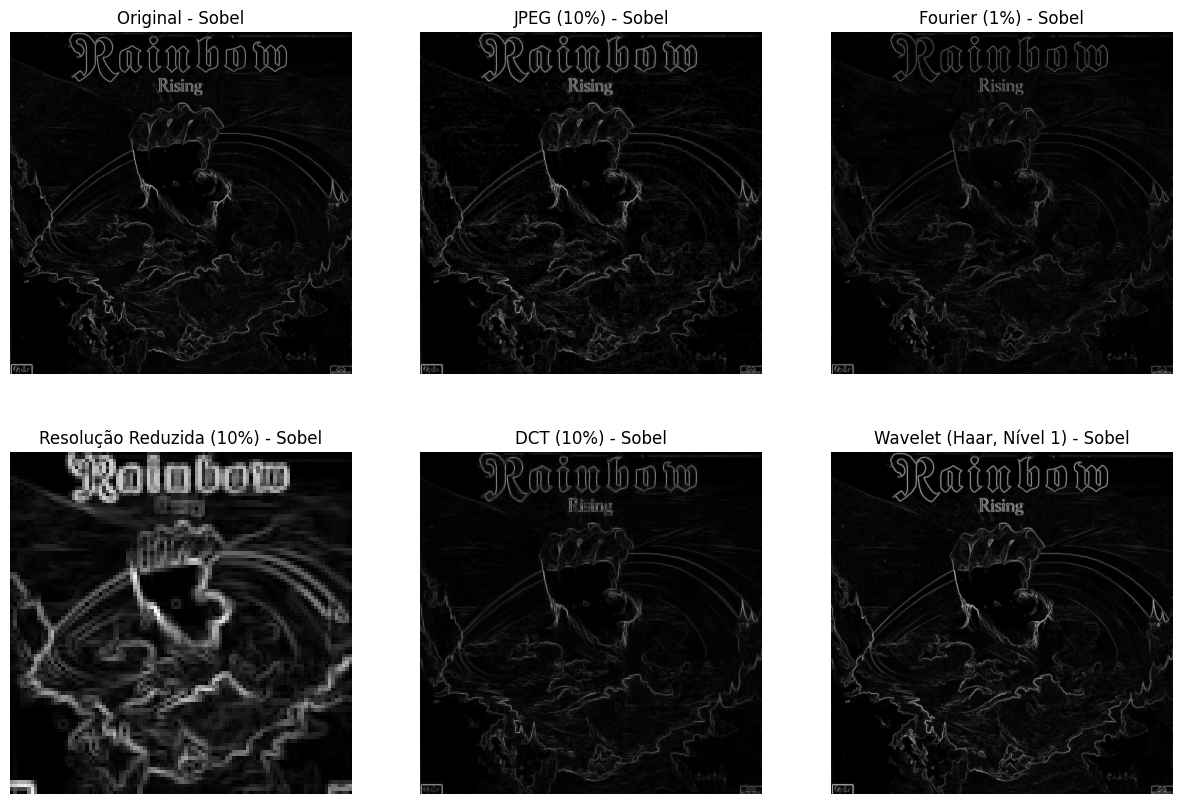

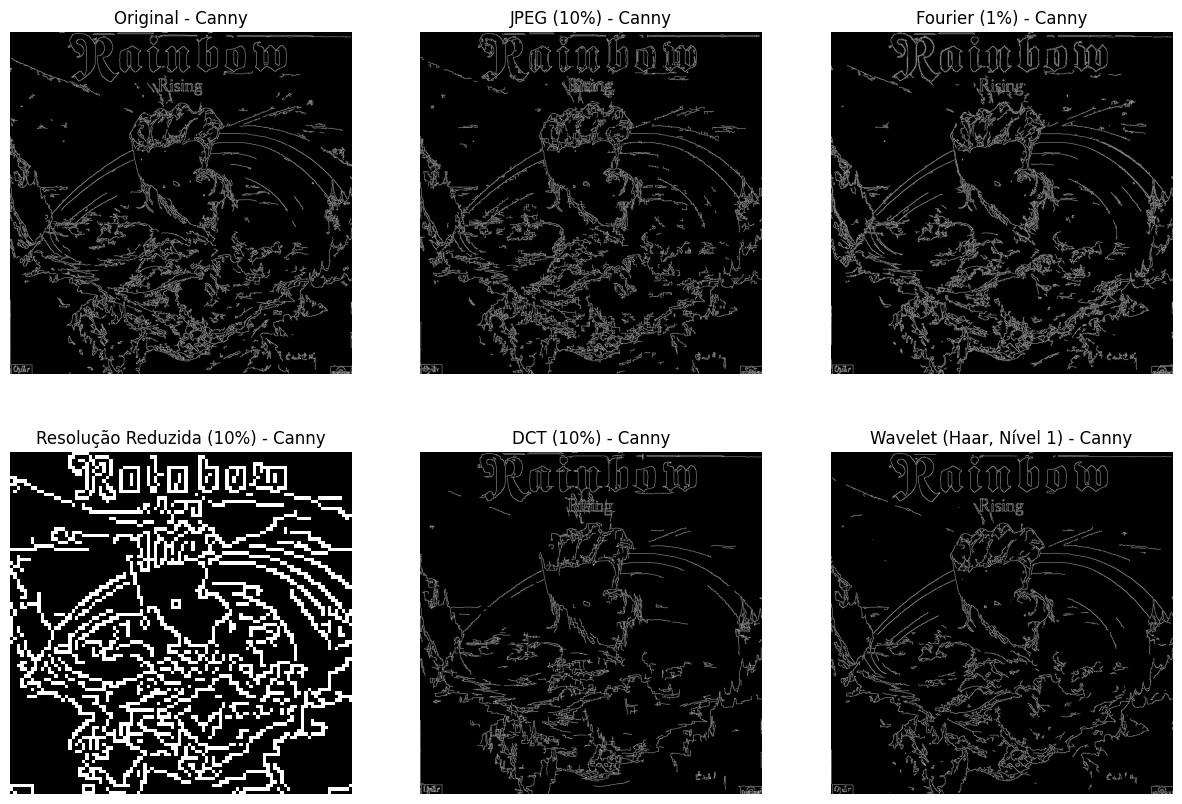

In [12]:
sobel_edges = [detect_edges_sobel(img) for img in images]
canny_edges = [detect_edges_canny(img) for img in images]

# Exibir resultados da detecção de bordas (Sobel)
sobel_titles = [
    'Original - Sobel', 
    'JPEG (10%) - Sobel', 
    'Fourier (1%) - Sobel', 
    'Resolução Reduzida (10%) - Sobel', 
    'DCT (10%) - Sobel', 
    'Wavelet (Haar, Nível 1) - Sobel'
]

display_images(sobel_edges, sobel_titles)

# Exibir resultados da detecção de bordas (Canny)
canny_titles = [
    'Original - Canny', 
    'JPEG (10%) - Canny', 
    'Fourier (1%) - Canny', 
    'Resolução Reduzida (10%) - Canny', 
    'DCT (10%) - Canny', 
    'Wavelet (Haar, Nível 1) - Canny'
]

display_images(canny_edges, canny_titles)